# Problem 6

## GNN for node classification and link prediction

In [1]:
# Import the libraries

import numpy as np

from tqdm import tqdm
from matplotlib import pyplot as plt

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.utils.data as Data
import matplotlib.pyplot as plt

from torch_geometric.datasets import Planetoid
import networkx as nx 

SEED = 0
torch.manual_seed(SEED)
np.random.seed(SEED)

torch.set_default_dtype(torch.float64)

In [2]:
dataset = Planetoid(root='/data', name='PubMed')

In [3]:
data = dataset[0]

# Let's have a look to how data are structured

data

Data(x=[19717, 500], edge_index=[2, 88648], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])

### Exploratory data analysis

#### Network structure

First of all, let's build the graph underlying our dataset to retrieve some precious informations. 

In [16]:
nodes_TFIDF = data.x
nodes_classes = data.y

nodes = torch.arange(0, nodes_TFIDF.shape[0])
edges = data.edge_index

Let's remap the tensor containing the edges to a data structure digestible by ```NetworkX```, that requires the edges to be 2-tuples:

In [17]:
edges

tensor([[ 1378,  1544,  6092,  ..., 12278,  4284, 16030],
        [    0,     0,     0,  ..., 19714, 19715, 19716]])

In [20]:
edges_tail = edges[0,:]
edges_head = edges[1,:]

edges = [(edges_tail[i].item(), edges_head[i].item()) for i in range(edges.shape[1])]

In [49]:
PubMed_graph = nx.Graph()

PubMed_graph.add_nodes_from(nodes.detach().numpy())
PubMed_graph.add_edges_from(edges)

Let's first of all have a look to the plain characteristics of the network:

In [33]:
print(f'There are {len(nodes)} nodes in the network')
print(f'There are {len(edges)} nodes in the network')

There are 19717 nodes in the network
There are 88648 nodes in the network


We expect the degree distribution to follow a power-law in the loglog scale and the network to be quite sparse:

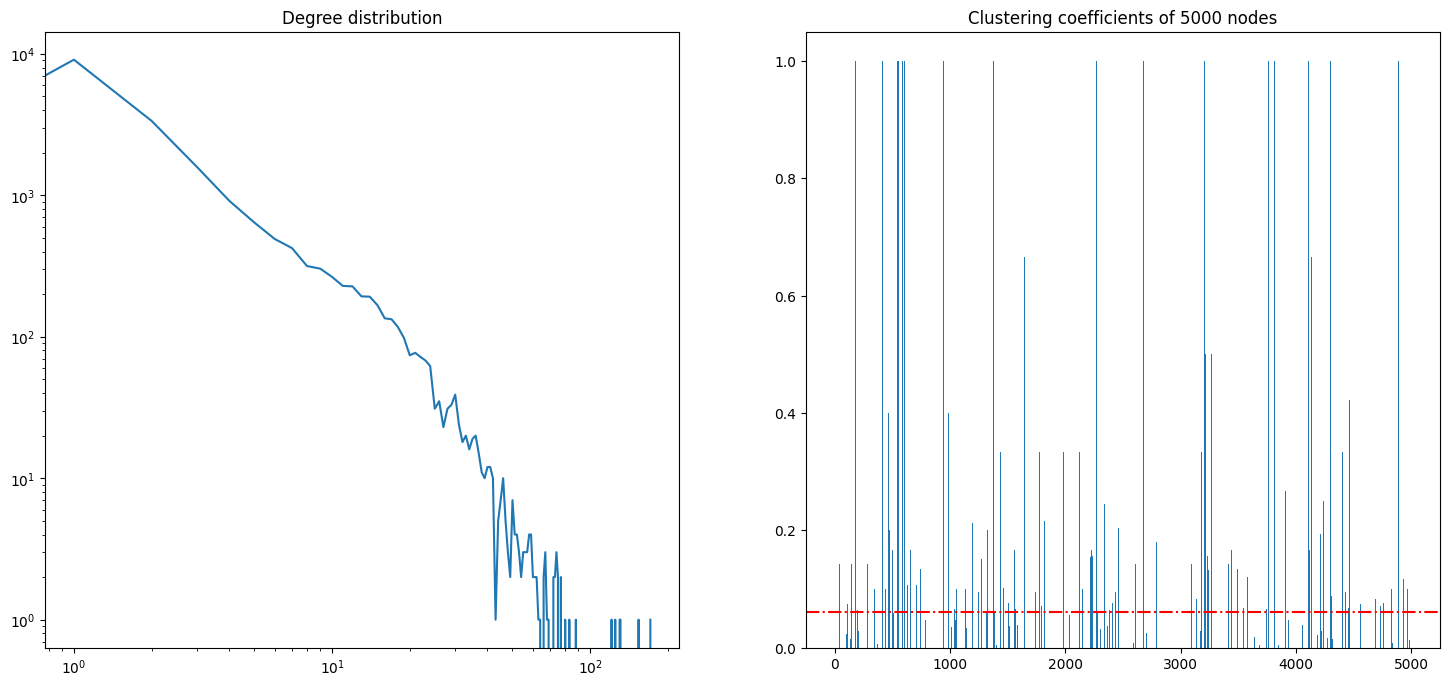

In [79]:
fig, axs = plt.subplots(1, 2, figsize=(18, 8))
axs[0].plot(nx.degree_histogram(PubMed_graph))
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].title.set_text('Degree distribution')

axs[1].bar(list(nx.clustering(PubMed_graph).keys())[:5000], list(nx.clustering(PubMed_graph).values())[:5000])
axs[1].axhline(y = nx.average_clustering(PubMed_graph), color = 'r', linestyle = '-.') 
axs[1].title.set_text('Clustering coefficients of 5000 nodes')

Indeed:

In [80]:
print(f'The average clustering coefficient of the network is {nx.average_clustering(PubMed_graph)}')

The average clustering coefficient of the network is 0.060175209437523615


If we consider the citation $(p_A, p_B)$ to be directed, we can retrieve as follows the average number of citations:

In [37]:
citations_out = {v.item():0 for v in nodes}
citations_in = {v.item():0 for v in nodes}

for edge in edges:
    citations_out[edge[0]] += 1
    citations_in[edge[1]] += 1

In [42]:
print(f'The average number of citations a paper does to other papers is {np.mean(list(citations_out.values()))}')
print(f'The average number of citations a paper receives from other papers is {np.mean(list(citations_in.values()))}')

The average number of citations a paper does to other papers is 4.496018664096972
The average number of citations a paper receives from other papers is 4.496018664096972
